In [3]:
from bnn.model import load_baysean_model, load_full_model, encoder_min_input_size
from bnn.data import test_train_batch_data, test_train_data
from bnn.util import BayesianConfig, open_pickle_file, full_path

from keras import backend as K
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
encoder = 'resnet50'
dataset = 'cifar10'
debug = False
monte_carlo_simulations = 100
min_image_size = (197,197,3)
full_model = False


In [21]:
(train_results, test_results) = open_pickle_file('predictions/resnet50_cifar10/results.p')

Unpickling file predictions/resnet50_cifar10/results.p


In [22]:
(train_images, _), (test_images, _) = cifar10.load_data()

In [23]:
train_results[1]

{'aleatoric_uncertainty': 1.6450747e-05,
 'epistemic_uncertainty': 0.45422709,
 'is_correct': 1,
 'label': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 'softmax': 9,
 'softmax_raw': array([  1.00354109e-05,   1.08593833e-02,   1.40199574e-09,
          4.82083010e-07,   4.80759299e-09,   1.46068814e-07,
          1.65970206e-07,   4.10091275e-07,   1.63216738e-03,
          9.87497211e-01], dtype=float32)}

In [24]:
def accuracy(results):
  return np.mean([x['is_correct'] for x in results])

print("train accuracy", accuracy(train_results))
print("test accuracy", accuracy(test_results))

train accuracy 0.95764
test accuracy 0.8721


In [25]:
def top_k_idx(arr, top_count):
  return np.argsort(arr, axis=1)[:, -top_count:]

def in_top(prediction, label):
  return label in prediction

def in_top_k(results, top_count):
  top_idx = top_k_idx([x['softmax_raw'] for x in results], top_count)
  labels = np.argmax([x['label'] for x in results], axis=1)
  return np.array([in_top(top_idx[i], labels[i]) for i in range(len(top_idx))])

def failure_idx(metrix_result):
  return np.nonzero(np.abs(metrix_result - 1))[0]

print("top 2 score train:", np.mean(in_top_k(train_results, 2).astype(int)))
top_2_failures = failure_idx(in_top_k(train_results, 2).astype(int))[0:7]
print("top 2 score test:", np.mean(in_top_k(test_results, 2).astype(int)))
top_2_failures_test = failure_idx(in_top_k(test_results, 2).astype(int))[0:7]

top 2 score train: 0.99124
top 2 score test: 0.9588


Max aleatoric_uncertainty for train is 0.300141
Max aleatoric_uncertainty for test is 0.134094
Max epistemic_uncertainty for train is 2.17239
Max epistemic_uncertainty for test is 2.09178


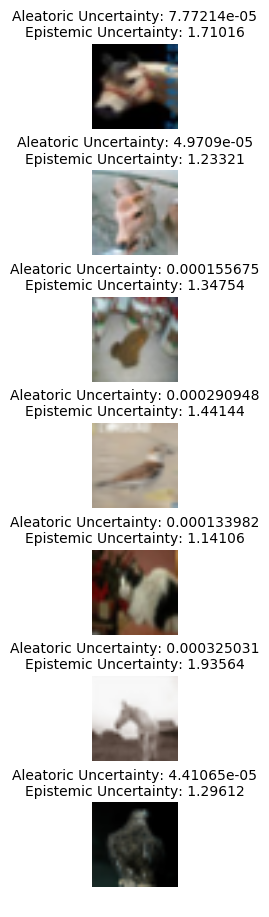

In [51]:
def display_k(name, images, aleatoric_uncertainties, epistemic_uncertainties):
  assert(len(images) == len(aleatoric_uncertainties))
  assert(len(images) == len(epistemic_uncertainties))
  f, axes = plt.subplots(len(images), 1, figsize=(24, 9))
  f.tight_layout()
  
  for i in range(len(axes)):
    axes[i].imshow(images[i])
    axes[i].set_title(
      'Aleatoric Uncertainty: ' + str(aleatoric_uncertainties[i]) + 
      '\nEpistemic Uncertainty: ' + str(epistemic_uncertainties[i])
      , fontsize=10)
    axes[i].axis('off')
  plt.show()

max_a_u_train = np.max([x['aleatoric_uncertainty'] for x in train_results])
max_a_u_test = np.max([x['aleatoric_uncertainty'] for x in test_results])
print("Max aleatoric_uncertainty for train is", max_a_u_train)
print("Max aleatoric_uncertainty for test is", max_a_u_test)
max_e_u_train = np.max([x['epistemic_uncertainty'] for x in train_results])
max_e_u_test = np.max([x['epistemic_uncertainty'] for x in test_results])
print("Max epistemic_uncertainty for train is", max_e_u_train)
print("Max epistemic_uncertainty for test is", max_e_u_test)
# display_k("train data", train_images[top_2_failures], 
#           [train_results[i]['aleatoric_uncertainty'] for i in top_2_failures],
#           [train_results[i]['epistemic_uncertainty'] for i in top_2_failures])
display_k("test data", test_images[top_2_failures_test], 
          [test_results[i]['aleatoric_uncertainty'] for i in top_2_failures_test],
          [test_results[i]['epistemic_uncertainty'] for i in top_2_failures_test])

In [49]:
def mean_uncertainty_by_class(uncertainties, labels):
  label_counts = np.zeros(np.max(labels)+1)
  total_uncertainty = np.zeros(np.max(labels)+1)
  for i in range(len(uncertainties)):
    label_counts[labels[i]] += 1
    total_uncertainty[labels[i]] += uncertainties[i]
    
  return total_uncertainty / label_counts


train_epistemic_class_mean = mean_uncertainty_by_class([x['epistemic_uncertainty'] for x in train_results], 
                          np.argmax([x['label'] for x in train_results], axis=1))
train_aleatoric_class_mean = mean_uncertainty_by_class([x['aleatoric_uncertainty'] for x in train_results], 
                          np.argmax([x['label'] for x in train_results], axis=1))
test_epistemic_class_mean = mean_uncertainty_by_class([x['epistemic_uncertainty'] for x in test_results], 
                          np.argmax([x['label'] for x in test_results], axis=1))
test_aleatoric_class_mean = mean_uncertainty_by_class([x['aleatoric_uncertainty'] for x in test_results], 
                          np.argmax([x['label'] for x in test_results], axis=1))
print("train_epistemic_class_mean:", train_epistemic_class_mean)
print("train_aleatoric_class_mean:", train_aleatoric_class_mean)
print("test_epistemic_class_mean:", test_epistemic_class_mean)
print("test_aleatoric_class_mean:", test_aleatoric_class_mean)

train_epistemic_class_mean: [ 0.49184559  0.31318248  0.55965612  0.83130249  0.68911752  0.63729139
  0.46141653  0.48181703  0.41308602  0.39599285]
train_aleatoric_class_mean: [  2.14166769e-04   7.83034024e-04   2.65898515e-04   6.47692116e-05
   1.52290927e-04   6.15171051e-04   5.15854042e-04   1.04763285e-03
   6.56497992e-04   2.94267220e-04]
test_epistemic_class_mean: [ 0.53954698  0.36723007  0.59765306  0.8629394   0.72922524  0.67001197
  0.50125655  0.51589493  0.43656398  0.41700791]
test_aleatoric_class_mean: [  2.24815559e-04   7.46679064e-04   2.95000709e-04   8.12034868e-05
   1.48585741e-04   4.24605538e-04   5.18459461e-04   9.51264520e-04
   6.70699133e-04   2.78054220e-04]


In [48]:
np.bincount(np.argmax([x['label'] for x in test_results], axis=1))

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])